In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision = 4)

def Conta_Classes(Label_Set):
    P = np.sum(np.equal(Label_Set, 1))
    N = np.sum(np.equal(Label_Set, 0))
    return np.array([P/(P+N), N/(P+N)])

Train_Images = np.load('train_images.npy')
Train_Labels = np.load('train_labels.npy')

Val_Images = np.load('val_images.npy')
Val_Labels = np.load('val_labels.npy')

Test_Images = np.load('test_images.npy')
Test_Labels = np.load('test_labels.npy')


#Conta_Classes(Train_Labels)
#Conta_Classes(Val_Labels)
#Conta_Classes(Test_Labels)

O balanço entre classes, obtido pela função *Conta_Classes* foi igual para os três conjuntos - treino, validação e teste:

- Positivo: **73.08%**
- Negativo: **26.92%**

Há uma predominância da classe positiva, aproximadamente 3 em cada 4 amostras pertencem a esta classe.

In [4]:
#Extração de atributos a partir das imagens

def Atributos(Image_Set, Dim_Image):
    Atributos_Test_Empilhados = np.empty((0, 88))
    for image in Image_Set:
        Soma = np.sum(image) / (Dim_Image ** 2)
        Traco = np.trace(image)
        Autovalores = np.linalg.eig(image)[0]
        Autovalores = np.absolute(Autovalores)
        Soma_Lin = np.array([0])
        Soma_Col = np.array([0])
        for lin in image:
            Soma_Lin = np.hstack((Soma_Lin, np.sum(lin) / Dim_Image))
        for col in image.T:
            Soma_Col = np.hstack((Soma_Col, np.sum(col) / Dim_Image))
        Atributos_Test = np.hstack((Soma, Autovalores, Traco, Soma_Lin, Soma_Col))
        Atributos_Test_Empilhados = np.vstack((Atributos_Test_Empilhados, Atributos_Test)) 
    Fi = np.hstack((np.ones((len(Atributos_Test_Empilhados), 1)), Atributos_Test_Empilhados))
    return Fi
    

Dim_Image = len(Train_Images[0])
Fi_Train = Atributos(Train_Images, Dim_Image)
Fi_Val   = Atributos(Val_Images, Dim_Image)
Fi_Test  = Atributos(Test_Images, Dim_Image)

A função Atributos, foi utilizada para extrair os seguintes atributos para cada imagem:

- Média da soma dos elementos.
- Traço da matriz.
- Valores absolutos dos autovalores.
- Média da soma dos elementos de cada linha.
- Média da soma dos elementos de cada coluna.

Outros atributos, como determinante e parte real dos autovalores, foram testados, contudo, os atributos acima foram os que proporcionaram os melhores resultados. Os atributos de cada imagem foram empilhados e a matriz Fi de cada conjunto - treino, validação e teste - foi gerada.

In [3]:
#Treinamento
def Calcula_Grad(Fi_Train, w, Train_Labels):
    E = np.empty((0, 1))
    for i in range(len(Fi_Train)):
        Label_Calc = 1 / (1 + np.exp(-(np.dot(Fi_Train[i], w))))
        Erro = Train_Labels[i][0] - Label_Calc
        E = np.vstack((E, Erro))
    Grad = - 1/len(Fi_Train) * (np.matmul(E.T, Fi_Train))
    return Grad[0]

w = np.loadtxt('Melhor_Parametro') 

#w = [1]
#w = len(Fi_Train[0])*w
#w = np.array(w)

#w = np.arange(0, 1, len(Fi_Train[0]))

Alfa = .0001
for i in range(3000):
    w  = w - Alfa * Calcula_Grad(Fi_Train, w, Train_Labels)
    if i % 1000 == 0: 
        print(i)
        


0
1000
2000


In [6]:
w = np.repeat(0.5, len(Fi_Train[0]))
w

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

Para o treinamento foi utilizado o método do gradiente descendente, em batelada, utilizando a função *Calcula_Grad*. A escolha é coerente com base no tamanho do conjunto de dados deste problema. O passo $\alpha$ e o número de épocas de treinamento foram ajustados com base nos melhores valores de Acurácia Balanceada e Precisão alcançados na etapa de validação. Isto foi obtido com $\alpha = .0001$ e $10000$ épocas. Além disso, foi observado que o valor inicial do vetor de parâmetros também altera fundamentalmente os resultados. Os melhores resultados foram obtios com uma inicialização aleatória, seguindo uma distribuição uniforme no conjunto $[0, 1)$.

In [224]:
#Validacao
Label_Calcs = np.empty((0,1))
for i in range(len(Fi_Val)):
    Label_Calc = 1 / (1 + np.exp(-(np.dot(Fi_Val[i], w)))) - 0.1 ** i
    if Label_Calc >= 0.5:
        Label_Calc = 1
    else:
        Label_Calc = 0
    Label_Calcs = np.vstack((Label_Calcs, Label_Calc))
    

TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 1))
FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 0))
FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 1))
TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 0))
    

Matriz_Conf = np.array([[TP, FN], 
                        [FP, TN]])    
    
Espe = TN / (TN + FP)
Sens = TP / (TP + FN)
Prec = TP / (TP + FP)
TFPo = FP / (TN + FP)

BA = (Espe + Sens) / 2
Acc = (TP + TN) / (TP + TN + FP + FN)
Fm = (2 * Sens * Prec) / (Sens + Prec)

BA


0.8345864661654135

Para a validação foi utilizado o vetor de parâmetros obtido na etapa de treinamento. O limite utilizado para a escolha da classe foi de 0.5. Se o padrão calculado for maior que 0.5 o classificador escolhe classe positiva, caso contrário, escolhe classe negativa. A matriz de confusão foi calculada e com base nela as métricas foram calculadas.

In [91]:
#Teste
Label_Calcs = np.empty((0,1))
Label_Calcs_Bruto = np.empty((0,1)) #Será usado para curva ROC
for i in range(len(Fi_Test)):
    Label_Calc = 1 / (1 + np.exp(-(np.dot(Fi_Test[i], w))))
    
    
    if Label_Calc == 1:
        Label_Calc -= np.absolute(np.random.rand(0.01, 0.1, 1))
    
    
    
    Label_Calcs_Bruto = np.vstack((Label_Calcs_Bruto, Label_Calc))
    
    if Label_Calc >= 0.5:
        Label_Calc = 1
    else:
        Label_Calc = 0
    Label_Calcs = np.vstack((Label_Calcs, Label_Calc))
    


TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 1))
FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 0))
FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 1))
TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 0))
    

Matriz_Conf = np.array([[TP, FN], 
                        [FP, TN]])    
    
Espe = TN / (TN + FP)
Sens = TP / (TP + FN)
Prec = TP / (TP + FP)
TFPo = FP / (TN + FP)

BA = (Espe + Sens) / 2
Acc = (TP + TN) / (TP + TN + FP + FN)
Fm = (2 * Sens * Prec) / (Sens + Prec)

BA


0.7487468671679198

111 27 3 15
110 26 4 16
109 22 5 20
108 21 6 21
107 20 7 22
106 20 8 22
105 20 9 22
104 19 10 23
103 19 11 23
102 19 12 23
101 18 13 24
100 18 14 24
99 18 15 24
98 17 16 25
97 17 17 25
96 17 18 25
95 17 19 25
94 17 20 25
93 13 21 29
92 13 22 29
91 13 23 29
90 13 24 29
89 13 25 29
88 13 26 29
87 13 27 29
86 13 28 29
85 13 29 29
84 13 30 29
83 13 31 29
82 11 32 31
80 11 34 31
76 11 38 31
75 11 39 31
74 11 40 31
72 11 42 31
71 11 43 31
69 10 45 32
68 10 46 32
66 10 48 32
65 10 49 32
63 10 51 32
62 10 52 32
61 10 53 32
60 10 54 32
55 10 59 32
53 10 61 32
52 10 62 32
51 9 63 33
50 9 64 33
48 9 66 33
46 9 68 33
45 9 69 33
43 9 71 33
40 9 74 33
39 8 75 34
36 8 78 34
34 8 80 34
31 8 83 34
29 8 85 34
28 7 86 35
25 6 89 36
22 5 92 37
18 3 96 39
13 3 101 39
11 3 103 39
0 0 114 42


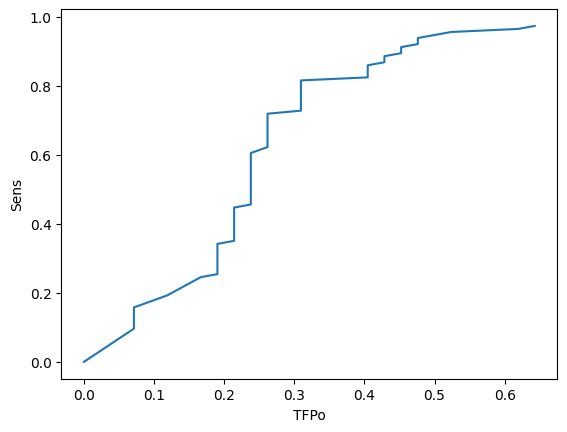

In [98]:
#Curva ROC

Sens = []
TFPo = []
Thresholds = np.logspace(-30, 0.000000000001, num=10000-0+1,base=10,dtype='float128')
TP_A = 0

for Threshold in Thresholds:
    
    Label_Calc_ROC = np.empty((0,1))
    
    
    
    for Label_Calc_Bruto in Label_Calcs_Bruto:
        if Label_Calc_Bruto < Threshold:
            Label_Calc_Bruto = 0
        else:
            Label_Calc_Bruto = 1
        Label_Calc_ROC = np.vstack((Label_Calc_ROC, Label_Calc_Bruto))
    #print(Threshold)
    #print(np.hstack((Label_Calcs_Bruto, Label_Calc_ROC)))

    TP_D = np.sum(np.equal(Label_Calc_ROC, 1) & np.equal(Test_Labels, 1))
    FP = np.sum(np.equal(Label_Calc_ROC, 1) & np.equal(Test_Labels, 0))
    FN = np.sum(np.equal(Label_Calc_ROC, 0) & np.equal(Test_Labels, 1))
    TN = np.sum(np.equal(Label_Calc_ROC, 0) & np.equal(Test_Labels, 0))
    
    if TP_A == TP_D:
        continue
        
    print(TP_D, FP, FN, TN)
    
    TP_A = TP_D

    Sens.append(TP_D / (TP_D + FN)) 
    TFPo.append(FP / (FP + TN))
    
fig, ax = plt.subplots()
ax.plot(TFPo, Sens)
ax.set_xlabel('TFPo')
ax.set_ylabel('Sens')
plt.show()


In [83]:
min(TFPo)

0.19047619047619047

Na etapa de teste foi utilizado o melhor vetor de parâmetros obtido na etapa de validação. Com ele os seguintes valores de métricas foram alcançados:

- Acurácia Balanceada  = **0.73**
- Acurácia             = **0.76**
- F-medida             = **0.83**

[[1.]]
[[1.]
 [1.]]
[[1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]

[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [

[[0.5]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5

[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [0.5]
 [1. ]
 [0. ]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [0. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0. ]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [0.5]
 [1. ]
 [0. ]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [0. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0. ]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [0. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [0.5]
 [1. ]
 [0. ]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [0. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0.

[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [0.5]
 [1. ]
 [0. ]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [0. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0. ]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0. ]
 [0. ]
 [0.5]
 [1. ]
 [0. ]
 [0. ]
 [0. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]]
[[0.5]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0.5]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [0.5]
 [1. ]
 [0. ]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [0. ]
 [1. ]
 [0.5]
 [1. ]
 [1. ]
 [0. ]
 [0.5]
 [0.5]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [0.5]
 [0. ]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0.5]
 [1. ]
 [0. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [1. ]
 [0. ]
 [0. ]
 [0.5]
 [1. ]
 [0. 

[[0.6667]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.3333]
 [1.    ]
 [0.3333]
 [1.    ]
 [0.6667]
 [1.    ]
 [0.6667]
 [0.    ]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [0.3333]
 [1.    ]
 [1.    ]]
[[0.6667]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.3333]
 [1.    ]
 [0.3333]
 [1.    ]
 [0.6667]
 [1.    ]
 [0.6667]
 [0.    ]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [0.3333]
 [1.    ]
 [1.    ]
 [0.6667]]
[[0.6667]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.6667

[[0.6667]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.3333]
 [1.    ]
 [0.3333]
 [1.    ]
 [0.6667]
 [1.    ]
 [0.6667]
 [0.    ]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [0.3333]
 [1.    ]
 [1.    ]
 [0.6667]
 [0.    ]
 [1.    ]
 [0.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [0.6667]
 [1.    ]
 [0.3333]
 [0.6667]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [1.    ]
 [0.    ]
 [0.3333]
 [0.6667]
 [0.6667]
 [0.3333]
 [0.    ]
 [0.3333]
 [1.    ]
 [1.    ]
 [0.3333]]
[[0.6667]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [1.    ]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.3333]
 [1.    ]

[[0.75]
 [0.75]
 [0.75]
 [0.5 ]
 [0.5 ]
 [0.75]
 [0.5 ]
 [0.75]
 [1.  ]
 [1.  ]
 [0.75]
 [0.5 ]
 [0.5 ]
 [0.75]
 [1.  ]
 [0.75]
 [0.5 ]
 [0.75]
 [0.25]
 [0.75]
 [0.5 ]
 [1.  ]
 [1.  ]
 [0.75]
 [1.  ]
 [0.75]
 [0.5 ]
 [1.  ]
 [0.25]
 [1.  ]
 [0.5 ]
 [1.  ]
 [0.75]
 [0.  ]
 [0.75]
 [0.75]
 [1.  ]
 [1.  ]
 [0.75]
 [1.  ]
 [1.  ]
 [0.5 ]
 [0.75]
 [1.  ]
 [0.5 ]
 [0.25]
 [1.  ]
 [0.25]
 [0.75]
 [0.75]
 [0.75]]
[[0.75]
 [0.75]
 [0.75]
 [0.5 ]
 [0.5 ]
 [0.75]
 [0.5 ]
 [0.75]
 [1.  ]
 [1.  ]
 [0.75]
 [0.5 ]
 [0.5 ]
 [0.75]
 [1.  ]
 [0.75]
 [0.5 ]
 [0.75]
 [0.25]
 [0.75]
 [0.5 ]
 [1.  ]
 [1.  ]
 [0.75]
 [1.  ]
 [0.75]
 [0.5 ]
 [1.  ]
 [0.25]
 [1.  ]
 [0.5 ]
 [1.  ]
 [0.75]
 [0.  ]
 [0.75]
 [0.75]
 [1.  ]
 [1.  ]
 [0.75]
 [1.  ]
 [1.  ]
 [0.5 ]
 [0.75]
 [1.  ]
 [0.5 ]
 [0.25]
 [1.  ]
 [0.25]
 [0.75]
 [0.75]
 [0.75]
 [1.  ]]
[[0.75]
 [0.75]
 [0.75]
 [0.5 ]
 [0.5 ]
 [0.75]
 [0.5 ]
 [0.75]
 [1.  ]
 [1.  ]
 [0.75]
 [0.5 ]
 [0.5 ]
 [0.75]
 [1.  ]
 [0.75]
 [0.5 ]
 [0.75]
 [0.25]
 [0.75]
 [0.5 ]
 [1.  

[[0.6]]
[[0.6]
 [0.8]]
[[0.6]
 [0.8]
 [0.8]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]
 [0.4]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]
 [0.4]
 [0.6]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]
 [0.4]
 [0.6]
 [0.8]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]
 [0.4]
 [0.6]
 [0.8]
 [0.8]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.

[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]
 [0.4]
 [0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.8]
 [0.4]
 [0.8]
 [0.6]
 [1. ]
 [1. ]
 [0.8]
 [0.8]
 [0.6]
 [0.4]
 [1. ]
 [0.4]
 [1. ]
 [0.6]
 [1. ]
 [0.8]
 [0.2]
 [0.8]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [1. ]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [0.6]
 [0.2]
 [1. ]
 [0.4]
 [0.8]
 [0.8]
 [0.8]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]
 [0.4]
 [0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.8]
 [0.4]
 [0.8]
 [0.6]
 [1. ]
 [1. ]
 [0.8]
 [0.8]
 [0.6]
 [0.4]
 [1. ]
 [0.4]
 [1. ]
 [0.6]
 [1. ]
 [0.8]
 [0.2]
 [0.8]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [1. ]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [0.6]
 [0.2]
 [1. ]
 [0.4]
 [0.8]
 [0.8]
 [0.8]
 [1. ]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]
 [0.4]
 [0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.8]
 [0.4]
 [0.8]
 [0.6]
 [1. ]
 [1. ]
 [0.8]
 [0.8]
 [0.6]
 [0.4]
 [1. ]
 [0.4]
 [1. ]
 [0.6]
 [1. ]
 [0.8]
 [0.2]
 [0.8]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [1.

[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]
 [0.4]
 [0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.8]
 [0.4]
 [0.8]
 [0.6]
 [1. ]
 [1. ]
 [0.8]
 [0.8]
 [0.6]
 [0.4]
 [1. ]
 [0.4]
 [1. ]
 [0.6]
 [1. ]
 [0.8]
 [0.2]
 [0.8]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [1. ]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [0.6]
 [0.2]
 [1. ]
 [0.4]
 [0.8]
 [0.8]
 [0.8]
 [1. ]
 [0.8]
 [0.8]
 [0.4]
 [0.8]
 [0.8]
 [1. ]
 [0.8]
 [1. ]
 [1. ]
 [1. ]
 [0. ]
 [0.6]
 [0.8]
 [0.8]
 [0.4]
 [0.4]
 [0.4]
 [0.8]
 [1. ]
 [0.4]
 [0.8]]
[[0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.6]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [0.4]
 [0.4]
 [0.6]
 [0.8]
 [0.8]
 [0.6]
 [0.8]
 [0.4]
 [0.8]
 [0.6]
 [1. ]
 [1. ]
 [0.8]
 [0.8]
 [0.6]
 [0.4]
 [1. ]
 [0.4]
 [1. ]
 [0.6]
 [1. ]
 [0.8]
 [0.2]
 [0.8]
 [0.8]
 [1. ]
 [1. ]
 [0.8]
 [1. ]
 [0.8]
 [0.6]
 [0.8]
 [1. ]
 [0.6]
 [0.2]
 [1. ]
 [0.4]
 [0.8]
 [0.8]
 [0.8]
 [1. ]
 [0.8]
 [0.8]
 [0.4]
 [0.8]
 [0.8]
 [1. ]
 [0.8]
 [1. ]
 [1. ]
 [1. ]
 [0. ]
 [0.6]
 [0.8]
 [0.8]
 [0.4]
 [0.4]
 [0.4]
 [0.8

[[0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.8333]
 [0.8333]
 [1.    ]
 [0.8333]
 [0.5   ]
 [0.5   ]
 [0.6667]
 [0.8333]
 [0.8333]
 [0.5   ]
 [0.6667]
 [0.5   ]
 [0.8333]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.8333]
 [0.8333]
 [0.6667]
 [0.3333]
 [1.    ]
 [0.5   ]
 [1.    ]
 [0.6667]
 [1.    ]
 [0.8333]
 [0.1667]
 [0.6667]
 [0.6667]
 [0.8333]
 [1.    ]
 [0.8333]
 [1.    ]
 [0.6667]
 [0.5   ]
 [0.8333]
 [1.    ]]
[[0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.8333]
 [0.8333]
 [1.    ]
 [0.8333]
 [0.5   ]
 [0.5   ]
 [0.6667]
 [0.8333]
 [0.8333]
 [0.5   ]
 [0.6667]
 [0.5   ]
 [0.8333]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.8333]
 [0.8333]
 [0.6667]
 [0.3333]
 [1.    ]
 [0.5   ]
 [1.    ]
 [0.6667]
 [1.    ]
 [0.8333]
 [0.1667]
 [0.6667]
 [0.6667]
 [0.8333]
 [1.    ]
 [0.8333]
 [1.    ]
 [0.6667]
 [0.5   ]
 [0.8333]
 [1.    ]
 [0.5   ]]
[[0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.8333]
 [0.8333]
 [1.    ]
 [0.8333

[[0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.8333]
 [0.8333]
 [1.    ]
 [0.8333]
 [0.5   ]
 [0.5   ]
 [0.6667]
 [0.8333]
 [0.8333]
 [0.5   ]
 [0.6667]
 [0.5   ]
 [0.8333]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.8333]
 [0.8333]
 [0.6667]
 [0.3333]
 [1.    ]
 [0.5   ]
 [1.    ]
 [0.6667]
 [1.    ]
 [0.8333]
 [0.1667]
 [0.6667]
 [0.6667]
 [0.8333]
 [1.    ]
 [0.8333]
 [1.    ]
 [0.6667]
 [0.5   ]
 [0.8333]
 [1.    ]
 [0.5   ]
 [0.3333]
 [1.    ]
 [0.3333]
 [0.8333]
 [0.8333]
 [0.8333]
 [1.    ]
 [0.6667]
 [0.6667]
 [0.3333]
 [0.8333]
 [0.8333]
 [1.    ]
 [0.8333]
 [0.8333]
 [1.    ]
 [1.    ]
 [0.    ]
 [0.6667]
 [0.8333]
 [0.8333]
 [0.5   ]
 [0.3333]
 [0.5   ]]
[[0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.6667]
 [0.8333]
 [0.5   ]
 [0.8333]
 [0.8333]
 [1.    ]
 [0.8333]
 [0.5   ]
 [0.5   ]
 [0.6667]
 [0.8333]
 [0.8333]
 [0.5   ]
 [0.6667]
 [0.5   ]
 [0.8333]
 [0.6667]
 [1.    ]
 [1.    ]
 [0.8333]
 [0.8333]
 [0.6667]
 [0.3333]
 [1.    ]
 [0.5   ]
 [1.    ]
 [0.6667]

[[0.4286]
 [0.5714]
 [0.7143]
 [0.4286]
 [0.7143]
 [0.8571]
 [0.5714]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.5714]
 [0.5714]
 [0.7143]
 [0.8571]
 [0.8571]
 [0.4286]
 [0.5714]]
[[0.4286]
 [0.5714]
 [0.7143]
 [0.4286]
 [0.7143]
 [0.8571]
 [0.5714]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.5714]
 [0.5714]
 [0.7143]
 [0.8571]
 [0.8571]
 [0.4286]
 [0.5714]
 [0.5714]]
[[0.4286]
 [0.5714]
 [0.7143]
 [0.4286]
 [0.7143]
 [0.8571]
 [0.5714]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.5714]
 [0.5714]
 [0.7143]
 [0.8571]
 [0.8571]
 [0.4286]
 [0.5714]
 [0.5714]
 [0.8571]]
[[0.4286]
 [0.5714]
 [0.7143]
 [0.4286]
 [0.7143]
 [0.8571]
 [0.5714]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.5714]
 [0.5714]
 [0.7143]
 [0.8571]
 [0.8571]
 [0.4286]
 [0.5714]
 [0.5714]
 [0.8571]
 [0.5714]]
[[0.4286]
 [0.5714]
 [0.7143]
 [0.4286]
 [0.7143]
 [0.8571]
 [0.5714]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.5714]
 [0.5714]
 [0.7143]
 [0.8571]
 [0.8571]
 [0.4286]
 [0.5714]
 [0.5714]
 [0.8571]
 [0.5714]
 [1.  

[[0.4286]
 [0.5714]
 [0.7143]
 [0.4286]
 [0.7143]
 [0.8571]
 [0.5714]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.5714]
 [0.5714]
 [0.7143]
 [0.8571]
 [0.8571]
 [0.4286]
 [0.5714]
 [0.5714]
 [0.8571]
 [0.5714]
 [1.    ]
 [1.    ]
 [0.8571]
 [0.8571]
 [0.7143]
 [0.4286]
 [1.    ]
 [0.4286]
 [1.    ]
 [0.7143]
 [1.    ]
 [0.8571]
 [0.2857]
 [0.5714]
 [0.7143]
 [0.8571]
 [1.    ]
 [0.8571]
 [1.    ]
 [0.7143]
 [0.4286]
 [0.8571]
 [1.    ]
 [0.5714]
 [0.4286]
 [1.    ]
 [0.4286]
 [0.8571]
 [0.8571]
 [0.8571]
 [1.    ]
 [0.7143]
 [0.7143]
 [0.4286]
 [0.8571]
 [0.8571]
 [1.    ]
 [0.8571]
 [0.8571]
 [0.8571]
 [1.    ]
 [0.    ]
 [0.5714]
 [0.8571]
 [0.8571]
 [0.5714]]
[[0.4286]
 [0.5714]
 [0.7143]
 [0.4286]
 [0.7143]
 [0.8571]
 [0.5714]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.8571]
 [0.5714]
 [0.5714]
 [0.7143]
 [0.8571]
 [0.8571]
 [0.4286]
 [0.5714]
 [0.5714]
 [0.8571]
 [0.5714]
 [1.    ]
 [1.    ]
 [0.8571]
 [0.8571]
 [0.7143]
 [0.4286]
 [1.    ]
 [0.4286]
 [1.    ]
 [0.7143]
 [1.    ]
 [0.8571]

[[0.375]
 [0.5  ]
 [0.625]
 [0.5  ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.625]
 [0.75 ]]
[[0.375]
 [0.5  ]
 [0.625]
 [0.5  ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.625]
 [0.75 ]
 [0.875]]
[[0.375]
 [0.5  ]
 [0.625]
 [0.5  ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.625]
 [0.75 ]
 [0.875]
 [0.875]]
[[0.375]
 [0.5  ]
 [0.625]
 [0.5  ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.625]
 [0.75 ]
 [0.875]
 [0.875]
 [0.375]]
[[0.375]
 [0.5  ]
 [0.625]
 [0.5  ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.625]
 [0.75 ]
 [0.875]
 [0.875]
 [0.375]
 [0.5  ]]
[[0.375]
 [0.5  ]
 [0.625]
 [0.5  ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.625]
 [0.75 ]
 [0.875]
 [0.875]
 [0.375]
 [0.5  ]
 [0.625]]
[[0.375]
 [0.5  ]
 [0.625]
 [0.5  ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.

[[0.375]
 [0.5  ]
 [0.625]
 [0.5  ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.625]
 [0.75 ]
 [0.875]
 [0.875]
 [0.375]
 [0.5  ]
 [0.625]
 [0.875]
 [0.625]
 [1.   ]
 [0.875]
 [0.75 ]
 [0.875]
 [0.75 ]
 [0.375]
 [1.   ]
 [0.5  ]
 [1.   ]
 [0.75 ]
 [0.875]
 [0.875]
 [0.375]
 [0.625]
 [0.625]
 [0.875]
 [1.   ]
 [0.875]
 [1.   ]
 [0.75 ]
 [0.375]
 [0.875]
 [0.875]
 [0.625]
 [0.5  ]
 [1.   ]
 [0.375]
 [0.875]
 [0.875]
 [0.875]
 [0.875]
 [0.625]
 [0.75 ]
 [0.375]
 [0.75 ]
 [0.875]
 [1.   ]
 [0.875]
 [0.875]
 [0.75 ]
 [1.   ]
 [0.125]
 [0.5  ]]
[[0.375]
 [0.5  ]
 [0.625]
 [0.5  ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.75 ]
 [0.625]
 [0.625]
 [0.75 ]
 [0.875]
 [0.875]
 [0.375]
 [0.5  ]
 [0.625]
 [0.875]
 [0.625]
 [1.   ]
 [0.875]
 [0.75 ]
 [0.875]
 [0.75 ]
 [0.375]
 [1.   ]
 [0.5  ]
 [1.   ]
 [0.75 ]
 [0.875]
 [0.875]
 [0.375]
 [0.625]
 [0.625]
 [0.875]
 [1.   ]
 [0.875]
 [1.   ]
 [0.75 ]
 [0.375]
 [0.875]
 [0.875]
 [0.625]
 [0.5  ]
 [1.   ]


[[0.4444]
 [0.5556]
 [0.6667]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.6667]]
[[0.4444]
 [0.5556]
 [0.6667]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]]
[[0.4444]
 [0.5556]
 [0.6667]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.8889]]
[[0.4444]
 [0.5556]
 [0.6667]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.8889]
 [0.8889]]
[[0.4444]
 [0.5556]
 [0.6667]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.8889]
 [0.8889]
 [0.4444]]
[[0.4444]
 [0.5556]
 [0.6667]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.8889]
 [0.8889]
 [0.4444]
 [0.5556]]
[[0.4444]
 [0.5556]
 [0.6667]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.

[[0.4444]
 [0.5556]
 [0.6667]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.8889]
 [0.8889]
 [0.4444]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [1.    ]
 [0.7778]
 [0.7778]
 [0.8889]
 [0.7778]
 [0.4444]
 [0.8889]
 [0.5556]
 [1.    ]
 [0.6667]
 [0.8889]
 [0.8889]
 [0.3333]
 [0.6667]
 [0.5556]
 [0.8889]
 [1.    ]
 [0.8889]
 [0.8889]
 [0.7778]
 [0.4444]
 [0.8889]
 [0.8889]
 [0.6667]
 [0.5556]
 [1.    ]
 [0.3333]
 [0.7778]
 [0.8889]
 [0.8889]
 [0.8889]
 [0.6667]
 [0.7778]
 [0.4444]
 [0.6667]
 [0.8889]
 [1.    ]
 [0.8889]
 [0.7778]
 [0.7778]
 [1.    ]
 [0.2222]
 [0.5556]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.4444]
 [0.5556]]
[[0.4444]
 [0.5556]
 [0.6667]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.6667]
 [0.7778]
 [0.8889]
 [0.8889]
 [0.4444]
 [0.5556]
 [0.6667]
 [0.7778]
 [0.6667]
 [1.    ]
 [0.7778]
 [0.7778]
 [0.8889]
 [0.7778]
 [0.4444]
 [0.8889]
 [0.5556]
 [1.    ]
 [0.6667]

[[0.4]
 [0.6]
 [0.7]
 [0.5]
 [0.6]
 [0.8]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.7]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.9]
 [0.5]
 [0.6]
 [0.6]
 [0.8]
 [0.7]
 [1. ]
 [0.8]
 [0.8]
 [0.9]
 [0.8]
 [0.5]
 [0.9]
 [0.6]
 [1. ]
 [0.6]
 [0.8]
 [0.8]
 [0.4]
 [0.6]
 [0.5]
 [0.9]
 [0.9]
 [0.9]
 [0.9]
 [0.8]
 [0.4]
 [0.9]
 [0.9]]
[[0.4]
 [0.6]
 [0.7]
 [0.5]
 [0.6]
 [0.8]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.7]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.9]
 [0.5]
 [0.6]
 [0.6]
 [0.8]
 [0.7]
 [1. ]
 [0.8]
 [0.8]
 [0.9]
 [0.8]
 [0.5]
 [0.9]
 [0.6]
 [1. ]
 [0.6]
 [0.8]
 [0.8]
 [0.4]
 [0.6]
 [0.5]
 [0.9]
 [0.9]
 [0.9]
 [0.9]
 [0.8]
 [0.4]
 [0.9]
 [0.9]
 [0.6]]
[[0.4]
 [0.6]
 [0.7]
 [0.5]
 [0.6]
 [0.8]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.7]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.9]
 [0.5]
 [0.6]
 [0.6]
 [0.8]
 [0.7]
 [1. ]
 [0.8]
 [0.8]
 [0.9]
 [0.8]
 [0.5]
 [0.9]
 [0.6]
 [1. ]
 [0.6]
 [0.8]
 [0.8]
 [0.4]
 [0.6]
 [0.5]
 [0.9]
 [0.9]
 [0.9]
 [0.9]
 [0.8]
 [0.4]
 [0.9]
 [0.9]
 [0.6]
 [0.6]]
[[0.4]
 [0.6]
 [0.7]
 [0.5]
 [0.6]
 [0.8]
 [0.7]
 [0

[[0.4]
 [0.6]
 [0.7]
 [0.5]
 [0.6]
 [0.8]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.7]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.9]
 [0.5]
 [0.6]
 [0.6]
 [0.8]
 [0.7]
 [1. ]
 [0.8]
 [0.8]
 [0.9]
 [0.8]
 [0.5]
 [0.9]
 [0.6]
 [1. ]
 [0.6]
 [0.8]
 [0.8]
 [0.4]
 [0.6]
 [0.5]
 [0.9]
 [0.9]
 [0.9]
 [0.9]
 [0.8]
 [0.4]
 [0.9]
 [0.9]
 [0.6]
 [0.6]
 [0.9]
 [0.4]
 [0.8]
 [0.9]
 [0.9]
 [0.9]
 [0.7]
 [0.7]
 [0.5]
 [0.6]
 [0.8]
 [1. ]
 [0.9]
 [0.8]
 [0.8]
 [0.9]
 [0.3]
 [0.6]
 [0.8]
 [0.7]
 [0.6]
 [0.5]
 [0.6]
 [0.6]
 [0.9]
 [0.5]]
[[0.4]
 [0.6]
 [0.7]
 [0.5]
 [0.6]
 [0.8]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.7]
 [0.7]
 [0.7]
 [0.8]
 [0.8]
 [0.9]
 [0.5]
 [0.6]
 [0.6]
 [0.8]
 [0.7]
 [1. ]
 [0.8]
 [0.8]
 [0.9]
 [0.8]
 [0.5]
 [0.9]
 [0.6]
 [1. ]
 [0.6]
 [0.8]
 [0.8]
 [0.4]
 [0.6]
 [0.5]
 [0.9]
 [0.9]
 [0.9]
 [0.9]
 [0.8]
 [0.4]
 [0.9]
 [0.9]
 [0.6]
 [0.6]
 [0.9]
 [0.4]
 [0.8]
 [0.9]
 [0.9]
 [0.9]
 [0.7]
 [0.7]
 [0.5]
 [0.6]
 [0.8]
 [1. ]
 [0.9]
 [0.8]
 [0.8]
 [0.9]
 [0.3]
 [0.6]
 [0.8]
 [0.7]
 [0.6]
 [0.5]
 [0.6]
 [0.6]
 [0.9

[[0.4545]
 [0.6364]
 [0.7273]
 [0.5455]
 [0.6364]
 [0.7273]
 [0.7273]
 [0.7273]
 [0.7273]
 [0.8182]
 [0.7273]
 [0.6364]
 [0.7273]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.4545]
 [0.6364]
 [0.5455]
 [0.8182]
 [0.7273]
 [0.9091]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.8182]
 [0.4545]
 [0.9091]
 [0.5455]
 [0.9091]
 [0.6364]
 [0.8182]
 [0.8182]
 [0.3636]
 [0.6364]
 [0.4545]
 [0.9091]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.8182]
 [0.4545]
 [0.8182]
 [0.9091]
 [0.6364]
 [0.6364]
 [0.9091]
 [0.4545]]
[[0.4545]
 [0.6364]
 [0.7273]
 [0.5455]
 [0.6364]
 [0.7273]
 [0.7273]
 [0.7273]
 [0.7273]
 [0.8182]
 [0.7273]
 [0.6364]
 [0.7273]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.4545]
 [0.6364]
 [0.5455]
 [0.8182]
 [0.7273]
 [0.9091]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.8182]
 [0.4545]
 [0.9091]
 [0.5455]
 [0.9091]
 [0.6364]
 [0.8182]
 [0.8182]
 [0.3636]
 [0.6364]
 [0.4545]
 [0.9091]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.8182]
 [0.4545]
 [0.8182]
 [0.9091]
 [0.6364]
 [0.6364]
 [0.9091]
 [0.4545]
 [0.8182]]
[[0.4545]
 [0.6364]
 [0.7273

[[0.4545]
 [0.6364]
 [0.7273]
 [0.5455]
 [0.6364]
 [0.7273]
 [0.7273]
 [0.7273]
 [0.7273]
 [0.8182]
 [0.7273]
 [0.6364]
 [0.7273]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.4545]
 [0.6364]
 [0.5455]
 [0.8182]
 [0.7273]
 [0.9091]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.8182]
 [0.4545]
 [0.9091]
 [0.5455]
 [0.9091]
 [0.6364]
 [0.8182]
 [0.8182]
 [0.3636]
 [0.6364]
 [0.4545]
 [0.9091]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.8182]
 [0.4545]
 [0.8182]
 [0.9091]
 [0.6364]
 [0.6364]
 [0.9091]
 [0.4545]
 [0.8182]
 [0.9091]
 [0.9091]
 [0.8182]
 [0.7273]
 [0.7273]
 [0.5455]
 [0.5455]
 [0.8182]
 [1.    ]
 [0.9091]
 [0.8182]
 [0.7273]
 [0.9091]
 [0.3636]
 [0.5455]
 [0.8182]
 [0.7273]
 [0.6364]
 [0.4545]
 [0.5455]
 [0.5455]
 [0.9091]]
[[0.4545]
 [0.6364]
 [0.7273]
 [0.5455]
 [0.6364]
 [0.7273]
 [0.7273]
 [0.7273]
 [0.7273]
 [0.8182]
 [0.7273]
 [0.6364]
 [0.7273]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.4545]
 [0.6364]
 [0.5455]
 [0.8182]
 [0.7273]
 [0.9091]
 [0.8182]
 [0.8182]
 [0.9091]
 [0.8182]
 [0.4545]
 [0.9091]
 [0.5455]

[[0.5   ]
 [0.6667]
 [0.75  ]
 [0.5833]
 [0.6667]
 [0.75  ]
 [0.75  ]
 [0.75  ]
 [0.6667]
 [0.8333]
 [0.75  ]
 [0.6667]
 [0.6667]
 [0.8333]
 [0.8333]
 [0.9167]
 [0.4167]
 [0.6667]
 [0.5833]
 [0.8333]
 [0.75  ]
 [0.8333]
 [0.75  ]
 [0.8333]
 [0.9167]
 [0.8333]
 [0.5   ]
 [0.8333]
 [0.5833]
 [0.9167]
 [0.6667]
 [0.8333]
 [0.75  ]
 [0.3333]
 [0.6667]
 [0.4167]
 [0.9167]
 [0.75  ]
 [0.8333]
 [0.8333]
 [0.8333]
 [0.5   ]]
[[0.5   ]
 [0.6667]
 [0.75  ]
 [0.5833]
 [0.6667]
 [0.75  ]
 [0.75  ]
 [0.75  ]
 [0.6667]
 [0.8333]
 [0.75  ]
 [0.6667]
 [0.6667]
 [0.8333]
 [0.8333]
 [0.9167]
 [0.4167]
 [0.6667]
 [0.5833]
 [0.8333]
 [0.75  ]
 [0.8333]
 [0.75  ]
 [0.8333]
 [0.9167]
 [0.8333]
 [0.5   ]
 [0.8333]
 [0.5833]
 [0.9167]
 [0.6667]
 [0.8333]
 [0.75  ]
 [0.3333]
 [0.6667]
 [0.4167]
 [0.9167]
 [0.75  ]
 [0.8333]
 [0.8333]
 [0.8333]
 [0.5   ]
 [0.75  ]]
[[0.5   ]
 [0.6667]
 [0.75  ]
 [0.5833]
 [0.6667]
 [0.75  ]
 [0.75  ]
 [0.75  ]
 [0.6667]
 [0.8333]
 [0.75  ]
 [0.6667]
 [0.6667]
 [0.8333]
 [0.8333

[[0.5   ]
 [0.6667]
 [0.75  ]
 [0.5833]
 [0.6667]
 [0.75  ]
 [0.75  ]
 [0.75  ]
 [0.6667]
 [0.8333]
 [0.75  ]
 [0.6667]
 [0.6667]
 [0.8333]
 [0.8333]
 [0.9167]
 [0.4167]
 [0.6667]
 [0.5833]
 [0.8333]
 [0.75  ]
 [0.8333]
 [0.75  ]
 [0.8333]
 [0.9167]
 [0.8333]
 [0.5   ]
 [0.8333]
 [0.5833]
 [0.9167]
 [0.6667]
 [0.8333]
 [0.75  ]
 [0.3333]
 [0.6667]
 [0.4167]
 [0.9167]
 [0.75  ]
 [0.8333]
 [0.8333]
 [0.8333]
 [0.5   ]
 [0.75  ]
 [0.9167]
 [0.6667]
 [0.6667]
 [0.9167]
 [0.5   ]
 [0.8333]
 [0.9167]
 [0.9167]
 [0.8333]
 [0.6667]
 [0.75  ]
 [0.5833]
 [0.5833]
 [0.8333]
 [1.    ]
 [0.9167]
 [0.8333]
 [0.75  ]
 [0.9167]
 [0.3333]
 [0.5833]
 [0.8333]
 [0.75  ]
 [0.6667]
 [0.4167]]
[[0.5   ]
 [0.6667]
 [0.75  ]
 [0.5833]
 [0.6667]
 [0.75  ]
 [0.75  ]
 [0.75  ]
 [0.6667]
 [0.8333]
 [0.75  ]
 [0.6667]
 [0.6667]
 [0.8333]
 [0.8333]
 [0.9167]
 [0.4167]
 [0.6667]
 [0.5833]
 [0.8333]
 [0.75  ]
 [0.8333]
 [0.75  ]
 [0.8333]
 [0.9167]
 [0.8333]
 [0.5   ]
 [0.8333]
 [0.5833]
 [0.9167]
 [0.6667]
 [0.8333]

[[0.5385]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.6154]
 [0.7692]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.6923]
 [0.6923]]
[[0.5385]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.6154]
 [0.7692]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]]
[[0.5385]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.6154]
 [0.7692]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.8462]]
[[0.5385]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.6154]
 [0.7692]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.8462]
 [0.9231]]
[[0.5385]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.6154]
 [0.7692]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.8462]
 [0.9231]
 [0.4615]]
[[0.5385]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.6154]
 [0.7692]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.8462]
 [0.9231]
 [0.4615]
 [0.6154]]
[[0.5385]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.6154]
 [0.7692]
 [0.

[[0.5385]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.6154]
 [0.7692]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.8462]
 [0.9231]
 [0.4615]
 [0.6154]
 [0.5385]
 [0.8462]
 [0.7692]
 [0.7692]
 [0.7692]
 [0.8462]
 [0.9231]
 [0.7692]
 [0.5385]
 [0.8462]
 [0.6154]
 [0.9231]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.3077]
 [0.6154]
 [0.4615]
 [0.9231]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.8462]
 [0.5385]
 [0.7692]
 [0.9231]
 [0.6154]
 [0.6154]
 [0.9231]
 [0.5385]
 [0.8462]
 [0.9231]
 [0.9231]
 [0.8462]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.5385]
 [0.8462]
 [1.    ]
 [0.9231]
 [0.8462]]
[[0.5385]
 [0.6923]
 [0.7692]
 [0.6154]
 [0.6154]
 [0.7692]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.6923]
 [0.6923]
 [0.8462]
 [0.8462]
 [0.9231]
 [0.4615]
 [0.6154]
 [0.5385]
 [0.8462]
 [0.7692]
 [0.7692]
 [0.7692]
 [0.8462]
 [0.9231]
 [0.7692]
 [0.5385]
 [0.8462]
 [0.6154]
 [0.9231]
 [0.6923]
 [0.8462]
 [0.7692]
 [0.3077]
 [0.6154]
 [0.4615]
 [0.9231]
 [0.6923]
 [0.8462]
 [0.7692]

[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]]
[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]
 [0.7143]]
[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]]
[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.7857]]
[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.7857]
 [0.7143]]
[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.7857]
 [0.7143]
 [0.7143]]
[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]]
[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.8571]]
[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [

[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.8571]
 [0.9286]
 [0.5   ]
 [0.6429]
 [0.5   ]
 [0.8571]
 [0.7143]
 [0.7143]
 [0.7857]
 [0.8571]
 [0.9286]
 [0.7143]
 [0.5   ]
 [0.8571]
 [0.6429]
 [0.9286]
 [0.6429]
 [0.8571]
 [0.7857]
 [0.2857]
 [0.6429]
 [0.5   ]
 [0.9286]
 [0.7143]
 [0.8571]
 [0.7857]
 [0.7857]
 [0.5   ]
 [0.7857]
 [0.9286]
 [0.6429]
 [0.6429]
 [0.9286]
 [0.5   ]
 [0.8571]
 [0.8571]
 [0.9286]
 [0.8571]
 [0.7143]
 [0.7857]
 [0.5714]
 [0.5   ]
 [0.8571]
 [1.    ]
 [0.9286]
 [0.8571]
 [0.6429]]
[[0.5714]
 [0.6429]
 [0.7857]
 [0.6429]
 [0.5714]
 [0.7857]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.7857]
 [0.7143]
 [0.7143]
 [0.8571]
 [0.8571]
 [0.9286]
 [0.5   ]
 [0.6429]
 [0.5   ]
 [0.8571]
 [0.7143]
 [0.7143]
 [0.7857]
 [0.8571]
 [0.9286]
 [0.7143]
 [0.5   ]
 [0.8571]
 [0.6429]
 [0.9286]
 [0.6429]
 [0.8571]
 [0.7857]
 [0.2857]
 [0.6429]
 [0.5   ]
 [0.9286]
 [0.7143]
 [0.8571]

[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8   ]]
[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8   ]
 [0.8   ]]
[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8   ]
 [0.8   ]
 [0.7333]]
[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]]
[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8667]]
[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8667]
 [0.8667]]
[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8667]
 [0.8667]
 [0.8667]]
[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0

[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8667]
 [0.8667]
 [0.8667]
 [0.5333]
 [0.6667]
 [0.4667]
 [0.8667]
 [0.7333]
 [0.6667]
 [0.7333]
 [0.8   ]
 [0.9333]
 [0.7333]
 [0.5333]
 [0.8   ]
 [0.6667]
 [0.8667]
 [0.6667]
 [0.8667]
 [0.8   ]
 [0.3333]
 [0.6667]
 [0.5333]
 [0.9333]
 [0.7333]
 [0.8667]
 [0.8   ]
 [0.7333]
 [0.5333]
 [0.8   ]
 [0.8667]
 [0.6   ]
 [0.6667]
 [0.9333]
 [0.5333]
 [0.8667]
 [0.8667]
 [0.9333]
 [0.8667]
 [0.7333]
 [0.8   ]
 [0.6   ]
 [0.5333]
 [0.8   ]
 [0.9333]
 [0.9333]
 [0.8667]
 [0.6667]
 [0.8667]]
[[0.6   ]
 [0.6   ]
 [0.8   ]
 [0.6667]
 [0.5333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8   ]
 [0.8   ]
 [0.7333]
 [0.7333]
 [0.8667]
 [0.8667]
 [0.8667]
 [0.5333]
 [0.6667]
 [0.4667]
 [0.8667]
 [0.7333]
 [0.6667]
 [0.7333]
 [0.8   ]
 [0.9333]
 [0.7333]
 [0.5333]
 [0.8   ]
 [0.6667]
 [0.8667]
 [0.6667]
 [0.8667]
 [0.8   ]
 [0.3333]
 [0.6667]
 [0.5333]
 [0.9333]
 [0.7333]

[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]]
[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]
 [0.75  ]]
[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]
 [0.75  ]
 [0.8125]]
[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]
 [0.75  ]
 [0.8125]
 [0.8125]]
[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]
 [0.75  ]
 [0.8125]
 [0.8125]
 [0.75  ]]
[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]
 [0.75  ]
 [0.8125]
 [0.8125]
 [0.75  ]
 [0.75  ]]
[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]
 [0.75  ]
 [0.8125]
 [0.8125]
 [0.75  ]
 [0.75  ]
 [0.875 ]]
[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]
 [0.75  ]
 [0.8125]
 [0.8125]
 [0.75  ]
 [0.75  ]
 [0.875 ]
 [0.875 ]]
[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [

[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]
 [0.75  ]
 [0.8125]
 [0.8125]
 [0.75  ]
 [0.75  ]
 [0.875 ]
 [0.875 ]
 [0.875 ]
 [0.5   ]
 [0.625 ]
 [0.5   ]
 [0.875 ]
 [0.75  ]
 [0.6875]
 [0.75  ]
 [0.75  ]
 [0.875 ]
 [0.75  ]
 [0.5625]
 [0.75  ]
 [0.6875]
 [0.875 ]
 [0.625 ]
 [0.8125]
 [0.75  ]
 [0.3125]
 [0.6875]
 [0.5625]
 [0.875 ]
 [0.75  ]
 [0.875 ]
 [0.8125]
 [0.6875]
 [0.5625]
 [0.8125]
 [0.875 ]
 [0.5625]
 [0.625 ]
 [0.9375]
 [0.5625]
 [0.875 ]
 [0.875 ]
 [0.9375]
 [0.875 ]]
[[0.625 ]
 [0.625 ]
 [0.75  ]
 [0.625 ]
 [0.5625]
 [0.75  ]
 [0.8125]
 [0.6875]
 [0.75  ]
 [0.8125]
 [0.8125]
 [0.75  ]
 [0.75  ]
 [0.875 ]
 [0.875 ]
 [0.875 ]
 [0.5   ]
 [0.625 ]
 [0.5   ]
 [0.875 ]
 [0.75  ]
 [0.6875]
 [0.75  ]
 [0.75  ]
 [0.875 ]
 [0.75  ]
 [0.5625]
 [0.75  ]
 [0.6875]
 [0.875 ]
 [0.625 ]
 [0.8125]
 [0.75  ]
 [0.3125]
 [0.6875]
 [0.5625]
 [0.875 ]
 [0.75  ]
 [0.875 ]
 [0.8125]
 [0.6875]
 [0.5625]
 [0.8125]
 [0.875 ]
 [0.5625]
 [0.625 ]
 [0.9375]
 [0.5625]

[[0.6471]]
[[0.6471]
 [0.6471]]
[[0.6471]
 [0.6471]
 [0.7647]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]
 [0.7647]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]
 [0.7647]
 [0.8235]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]
 [0.7647]
 [0.8235]
 [0.7647]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]
 [0.7647]
 [0.8235]
 [0.7647]
 [0.7059]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]
 [0.7647]
 [0.8235]
 [0.7647]
 [0.7059]
 [0.7647]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.647

[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]
 [0.7647]
 [0.8235]
 [0.7647]
 [0.7059]
 [0.7647]
 [0.8824]
 [0.8824]
 [0.8824]
 [0.4706]
 [0.6471]
 [0.5294]
 [0.8824]
 [0.7059]
 [0.7059]
 [0.7647]
 [0.7647]
 [0.8235]
 [0.7647]
 [0.5294]
 [0.7059]
 [0.7059]
 [0.8824]
 [0.5882]
 [0.8235]
 [0.7059]
 [0.3529]
 [0.7059]
 [0.5294]
 [0.8824]
 [0.7059]
 [0.8824]
 [0.8235]
 [0.7059]
 [0.5294]
 [0.8235]
 [0.8824]
 [0.5882]
 [0.6471]
 [0.9412]
 [0.5882]
 [0.8824]
 [0.8235]
 [0.9412]
 [0.8824]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]
 [0.7647]
 [0.8235]
 [0.7647]
 [0.7059]
 [0.7647]
 [0.8824]
 [0.8824]
 [0.8824]
 [0.4706]
 [0.6471]
 [0.5294]
 [0.8824]
 [0.7059]
 [0.7059]
 [0.7647]
 [0.7647]
 [0.8235]
 [0.7647]
 [0.5294]
 [0.7059]
 [0.7059]
 [0.8824]
 [0.5882]
 [0.8235]
 [0.7059]
 [0.3529]
 [0.7059]
 [0.5294]
 [0.8824]
 [0.7059]
 [0.8824]
 [0.8235]
 [0.7059]
 [0.5294]
 [0.8235]
 [0.8824]
 [0.5882]
 [0.6471]
 [0.9412]
 [0.5882]

[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]
 [0.7647]
 [0.8235]
 [0.7647]
 [0.7059]
 [0.7647]
 [0.8824]
 [0.8824]
 [0.8824]
 [0.4706]
 [0.6471]
 [0.5294]
 [0.8824]
 [0.7059]
 [0.7059]
 [0.7647]
 [0.7647]
 [0.8235]
 [0.7647]
 [0.5294]
 [0.7059]
 [0.7059]
 [0.8824]
 [0.5882]
 [0.8235]
 [0.7059]
 [0.3529]
 [0.7059]
 [0.5294]
 [0.8824]
 [0.7059]
 [0.8824]
 [0.8235]
 [0.7059]
 [0.5294]
 [0.8235]
 [0.8824]
 [0.5882]
 [0.6471]
 [0.9412]
 [0.5882]
 [0.8824]
 [0.8235]
 [0.9412]
 [0.8824]
 [0.7059]
 [0.8235]
 [0.6471]
 [0.5294]
 [0.8235]
 [0.8824]
 [0.8824]
 [0.8824]
 [0.6471]
 [0.8824]
 [0.4118]
 [0.4706]
 [0.8824]
 [0.8235]
 [0.7059]
 [0.5294]
 [0.6471]
 [0.5882]
 [0.8235]
 [0.6471]
 [0.8235]
 [0.7059]
 [0.6471]
 [0.8235]
 [0.8824]]
[[0.6471]
 [0.6471]
 [0.7647]
 [0.6471]
 [0.5294]
 [0.7647]
 [0.7647]
 [0.6471]
 [0.7647]
 [0.8235]
 [0.7647]
 [0.7059]
 [0.7647]
 [0.8824]
 [0.8824]
 [0.8824]
 [0.4706]
 [0.6471]
 [0.5294]
 [0.8824]
 [0.7059]
 [0.7059]
 [0.7647]

[[0.6667]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.5556]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.7222]
 [0.8333]
 [0.7222]
 [0.7222]
 [0.7222]
 [0.8889]
 [0.8333]
 [0.8889]
 [0.5   ]
 [0.6111]
 [0.5   ]
 [0.8889]
 [0.7222]
 [0.7222]
 [0.7222]
 [0.7778]
 [0.8333]
 [0.7778]
 [0.5   ]
 [0.7222]
 [0.6667]
 [0.8889]
 [0.5556]
 [0.8333]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.5556]
 [0.8889]
 [0.7222]
 [0.8889]
 [0.8333]
 [0.7222]
 [0.5556]
 [0.7778]
 [0.8333]
 [0.6111]]
[[0.6667]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.5556]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.7222]
 [0.8333]
 [0.7222]
 [0.7222]
 [0.7222]
 [0.8889]
 [0.8333]
 [0.8889]
 [0.5   ]
 [0.6111]
 [0.5   ]
 [0.8889]
 [0.7222]
 [0.7222]
 [0.7222]
 [0.7778]
 [0.8333]
 [0.7778]
 [0.5   ]
 [0.7222]
 [0.6667]
 [0.8889]
 [0.5556]
 [0.8333]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.5556]
 [0.8889]
 [0.7222]
 [0.8889]
 [0.8333]
 [0.7222]
 [0.5556]
 [0.7778]
 [0.8333]
 [0.6111]
 [0.6667]]
[[0.6667]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.5556]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.7222

[[0.6667]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.5556]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.7222]
 [0.8333]
 [0.7222]
 [0.7222]
 [0.7222]
 [0.8889]
 [0.8333]
 [0.8889]
 [0.5   ]
 [0.6111]
 [0.5   ]
 [0.8889]
 [0.7222]
 [0.7222]
 [0.7222]
 [0.7778]
 [0.8333]
 [0.7778]
 [0.5   ]
 [0.7222]
 [0.6667]
 [0.8889]
 [0.5556]
 [0.8333]
 [0.6667]
 [0.3333]
 [0.6667]
 [0.5556]
 [0.8889]
 [0.7222]
 [0.8889]
 [0.8333]
 [0.7222]
 [0.5556]
 [0.7778]
 [0.8333]
 [0.6111]
 [0.6667]
 [0.9444]
 [0.6111]
 [0.8889]
 [0.8333]
 [0.9444]
 [0.8889]
 [0.7222]
 [0.8333]
 [0.6667]
 [0.5556]
 [0.8333]
 [0.8889]
 [0.8889]
 [0.8889]
 [0.6667]
 [0.8889]
 [0.3889]
 [0.5   ]
 [0.8889]
 [0.8333]
 [0.6667]
 [0.5   ]
 [0.6111]
 [0.6111]
 [0.8333]
 [0.6111]]
[[0.6667]
 [0.6667]
 [0.7778]
 [0.6667]
 [0.5556]
 [0.7778]
 [0.7778]
 [0.6667]
 [0.7222]
 [0.8333]
 [0.7222]
 [0.7222]
 [0.7222]
 [0.8889]
 [0.8333]
 [0.8889]
 [0.5   ]
 [0.6111]
 [0.5   ]
 [0.8889]
 [0.7222]
 [0.7222]
 [0.7222]
 [0.7778]
 [0.8333]
 [0.7778]
 [0.5   ]
 [0.7222]

[[0.6316]
 [0.6316]
 [0.7895]
 [0.6316]
 [0.5263]
 [0.7895]
 [0.7368]
 [0.6316]
 [0.7368]
 [0.8421]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.8947]
 [0.8421]
 [0.8421]
 [0.4737]
 [0.6316]
 [0.5263]
 [0.8947]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.7895]
 [0.8421]
 [0.7895]
 [0.5263]
 [0.7368]
 [0.6842]
 [0.8947]
 [0.5789]
 [0.8421]
 [0.6842]
 [0.3158]
 [0.6842]
 [0.5263]
 [0.8947]
 [0.6842]]
[[0.6316]
 [0.6316]
 [0.7895]
 [0.6316]
 [0.5263]
 [0.7895]
 [0.7368]
 [0.6316]
 [0.7368]
 [0.8421]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.8947]
 [0.8421]
 [0.8421]
 [0.4737]
 [0.6316]
 [0.5263]
 [0.8947]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.7895]
 [0.8421]
 [0.7895]
 [0.5263]
 [0.7368]
 [0.6842]
 [0.8947]
 [0.5789]
 [0.8421]
 [0.6842]
 [0.3158]
 [0.6842]
 [0.5263]
 [0.8947]
 [0.6842]
 [0.8947]]
[[0.6316]
 [0.6316]
 [0.7895]
 [0.6316]
 [0.5263]
 [0.7895]
 [0.7368]
 [0.6316]
 [0.7368]
 [0.8421]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.8947]
 [0.8421]
 [0.8421]
 [0.4737]
 [0.6316]
 [0.5263]
 [0.8947]
 [0.7368]
 [0.7368]
 [0.7368

[[0.6316]
 [0.6316]
 [0.7895]
 [0.6316]
 [0.5263]
 [0.7895]
 [0.7368]
 [0.6316]
 [0.7368]
 [0.8421]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.8947]
 [0.8421]
 [0.8421]
 [0.4737]
 [0.6316]
 [0.5263]
 [0.8947]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.7895]
 [0.8421]
 [0.7895]
 [0.5263]
 [0.7368]
 [0.6842]
 [0.8947]
 [0.5789]
 [0.8421]
 [0.6842]
 [0.3158]
 [0.6842]
 [0.5263]
 [0.8947]
 [0.6842]
 [0.8947]
 [0.8421]
 [0.7368]
 [0.5789]
 [0.7895]
 [0.8421]
 [0.6316]
 [0.6842]
 [0.9474]
 [0.6316]
 [0.8947]
 [0.8421]
 [0.9474]
 [0.8947]
 [0.7368]
 [0.8421]
 [0.6842]
 [0.5789]
 [0.8421]]
[[0.6316]
 [0.6316]
 [0.7895]
 [0.6316]
 [0.5263]
 [0.7895]
 [0.7368]
 [0.6316]
 [0.7368]
 [0.8421]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.8947]
 [0.8421]
 [0.8421]
 [0.4737]
 [0.6316]
 [0.5263]
 [0.8947]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.7895]
 [0.8421]
 [0.7895]
 [0.5263]
 [0.7368]
 [0.6842]
 [0.8947]
 [0.5789]
 [0.8421]
 [0.6842]
 [0.3158]
 [0.6842]
 [0.5263]
 [0.8947]
 [0.6842]
 [0.8947]
 [0.8421]
 [0.7368]
 [0.5789]
 [0.7895]

[[0.6316]
 [0.6316]
 [0.7895]
 [0.6316]
 [0.5263]
 [0.7895]
 [0.7368]
 [0.6316]
 [0.7368]
 [0.8421]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.8947]
 [0.8421]
 [0.8421]
 [0.4737]
 [0.6316]
 [0.5263]
 [0.8947]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.7895]
 [0.8421]
 [0.7895]
 [0.5263]
 [0.7368]
 [0.6842]
 [0.8947]
 [0.5789]
 [0.8421]
 [0.6842]
 [0.3158]
 [0.6842]
 [0.5263]
 [0.8947]
 [0.6842]
 [0.8947]
 [0.8421]
 [0.7368]
 [0.5789]
 [0.7895]
 [0.8421]
 [0.6316]
 [0.6842]
 [0.9474]
 [0.6316]
 [0.8947]
 [0.8421]
 [0.9474]
 [0.8947]
 [0.7368]
 [0.8421]
 [0.6842]
 [0.5789]
 [0.8421]
 [0.8947]
 [0.8947]
 [0.8947]
 [0.6842]
 [0.8947]
 [0.4211]
 [0.4737]
 [0.8947]
 [0.7895]
 [0.6842]
 [0.5263]
 [0.6316]
 [0.6316]
 [0.7895]
 [0.6316]
 [0.8421]
 [0.6842]
 [0.6842]
 [0.7895]]
[[0.6316]
 [0.6316]
 [0.7895]
 [0.6316]
 [0.5263]
 [0.7895]
 [0.7368]
 [0.6316]
 [0.7368]
 [0.8421]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.8947]
 [0.8421]
 [0.8421]
 [0.4737]
 [0.6316]
 [0.5263]
 [0.8947]
 [0.7368]
 [0.7368]
 [0.7368]
 [0.7895]

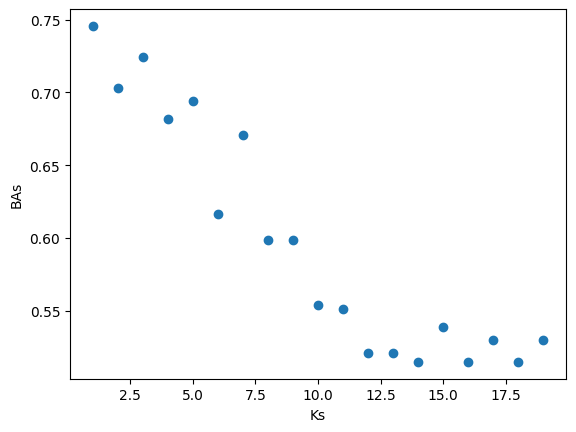

In [99]:
# Knn para a validação


 
def KNN(K, Fi_Set, Fi_Train):
    Label_Calcs_Bruto = np.empty((0,1))
    Label_Calcs = np.empty((0,1))
    for Novo_Padrao in Fi_Set[:, 1:len(Fi_Set[0])]:
        Distancias = np.empty((0, 2))
        for Padrao, Label in zip(Fi_Train[:, 1:len(Fi_Train[0])], Train_Labels):
            Distancia = [np.linalg.norm(Novo_Padrao - Padrao), Label[0]]
            Distancias = np.vstack((Distancias, Distancia))
        Distancias = np.sort(Distancias.view('f8, f8'), order=['f0'], axis=0)
        Distancias = Distancias[0:K]
        Distancias = Distancias.view(dtype = np.float64)
        Label_Calc = np.sum(Distancias, axis = 0)[1] / K
        Label_Calcs_Bruto = np.vstack((Label_Calcs_Bruto, Label_Calc))
        if Label_Calc >= .5:
            Label_Calc = 1
        else:
            Label_Calc = 0
        Label_Calcs = np.vstack((Label_Calcs, Label_Calc))
    return Label_Calcs, Label_Calcs_Bruto

Ks = []
BAs = []
for K in range(1, 20, 1):    
    
    Label_Calcs, Label_Calcs_Bruto = KNN(K, Fi_Val, Fi_Train)

    TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 1))
    FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Val_Labels, 0))
    FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 1))
    TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Val_Labels, 0))


    Matriz_Conf = np.array([[TP, FN], 
                            [FP, TN]])    

    Espe = TN / (TN + FP)
    Sens = TP / (TP + FN)
    Prec = TP / (TP + FP)
    TFPo = FP / (TN + FP)

    BA = (Espe + Sens) / 2
    Acc = (TP + TN) / (TP + TN + FP + FN)
    Fm = (2 * Sens * Prec) / (Sens + Prec)
    
    BAs.append(BA)
    Ks.append(K)

fig, ax = plt.subplots()
ax.scatter(Ks, BAs)
ax.set_xlabel('Ks')
ax.set_ylabel('BAs')
plt.show()

        

In [103]:
# Knn para o teste com K = 1
K = 1
Label_Calcs, Label_Calcs_Bruto = KNN(K, Fi_Test, Fi_Train)

TP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 1))
FP = np.sum(np.equal(Label_Calcs, 1) & np.equal(Test_Labels, 0))
FN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 1))
TN = np.sum(np.equal(Label_Calcs, 0) & np.equal(Test_Labels, 0))


Matriz_Conf = np.array([[TP, FN], 
                        [FP, TN]])    

Espe = TN / (TN + FP)
Sens = TP / (TP + FN)
Prec = TP / (TP + FP)
TFPo = FP / (TN + FP)

BA = (Espe + Sens) / 2
Acc = (TP + TN) / (TP + TN + FP + FN)
Fm = (2 * Sens * Prec) / (Sens + Prec)


[[1.]]
[[1.]
 [0.]]
[[1.]
 [0.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0

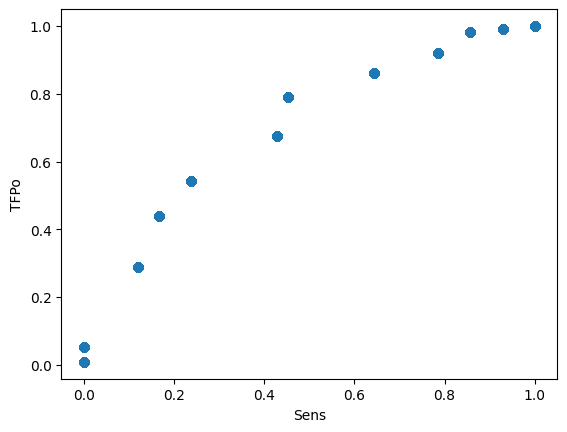

In [102]:
#Curva ROC

Sens = []
TFPo = []
Thresholds = np.arange(0, 1, 0.0001)

for Threshold in Thresholds:
    
    Label_Calc_ROC = np.empty((0,1))
    for Label_Calc_Bruto in Label_Calcs_Bruto:
        if Label_Calc_Bruto >= Threshold:
            Label_Calc_Bruto = 1
        else:
            Label_Calc_Bruto = 0
        Label_Calc_ROC = np.vstack((Label_Calc_ROC, Label_Calc_Bruto))
    #print(Label_Calc_ROC)

    TP = np.sum(np.equal(Label_Calc_ROC, 1) & np.equal(Test_Labels, 1))
    FP = np.sum(np.equal(Label_Calc_ROC, 1) & np.equal(Test_Labels, 0))
    FN = np.sum(np.equal(Label_Calc_ROC, 0) & np.equal(Test_Labels, 1))
    TN = np.sum(np.equal(Label_Calc_ROC, 0) & np.equal(Test_Labels, 0))
    
    #print(TP, FP, FN, TN)

    Sens.append(TP / (TP + FN)) 
    TFPo.append(FP / (FP + TN))
    
fig, ax = plt.subplots()
ax.scatter(TFPo, Sens)
ax.set_xlabel('Sens')
ax.set_ylabel('TFPo')
plt.show()


In [81]:
np.absolute(np.random.logistic(0.001, 0.1, 1))

array([0.1875])

Se ele chutar todos como 1 -> TP / TP + FN = 113 / 113 + 0 = 1; FP / FP + TN = 42 / 42 + 0 = 1
Se ele chutar todos como 0 -> TP / TP + FN = 0 / 0 + 113 = 0; FP / FP + TN = 0 / 0 + 72 = 0 